Shopee, a Sea company, is a leading online shopping platform that originated in Singapore in 2015 before expanding internationally. It is the largest eCommerce platform in Southeast Asia, serving both sellers and consumers and offering goods by major retailers and local merchants.

Until this day, Shopee has emerged as one of the largest ecommerce platforms in Vietnam specifically. This project is carried out with the purpose of understanding the spending habit of the customers of Shopee and segment them to different parts. This finding would help Shopee to offer a tailored solution to each type of customers corresponding to their spending habits.
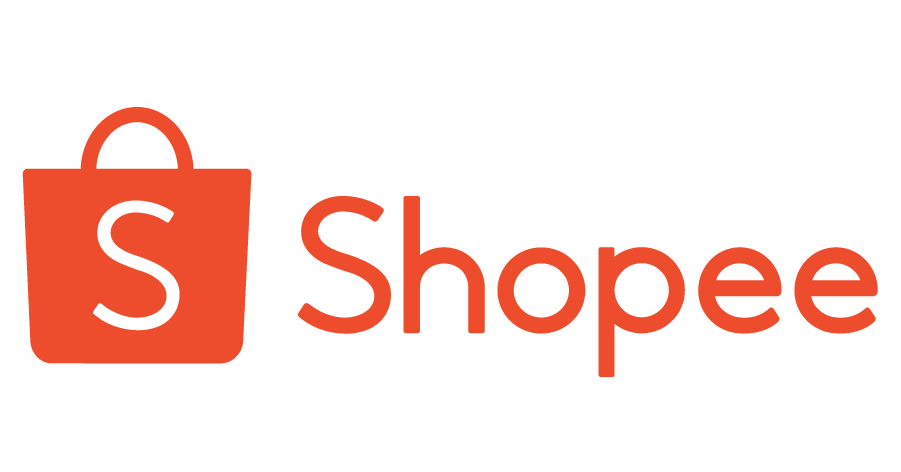

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import plotly.offline as pyoff
import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# DATASET

The dataset is read through the library pandas

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Compulsory Elective Subject - Andersson/Customer_Segmentation_Data.xlsx')

In [ ]:
# Observe the first 5 lines of the dataframe
df.head(5)

,Gender,Age,Net_Income,Average_Order,Spending_Per_Order,Payment_Method,Other_Eplatform
0,Female,18,6000000.0,6,100.000 - 300.000,Electronic Wallet,Yes
1,Female,21,6500000.0,5,100.000 - 300.000,Electronic Wallet,Yes
2,Male,25,7000000.0,3,100.000 - 300.000,Electronic Wallet,Yes
3,Female,23,7000000.0,8,100.000 - 300.000,Electronic Wallet,Yes
4,Female,27,9000000.0,6,100.000 - 300.000,Electronic Wallet,Yes


In [ ]:
print('The dimension of the dataset is: ', df.shape) # 229 rows and 7 columns

The dimension of the dataset is:  (229, 7)


The dataframe contains 7 columns which are
* Gender: Female or male
* Age
* Net_Income: Income after tax
* Average_Order: number of orders on average you make on a monthly basis on Shopee
* Spending_Per_Order: Amount money on average that you spend for an order on Shopee (VND)
* Payment Method: Payment method do you choose on Shopee
* Other_EPlatform: Whether you use any other e-commerce platform


# DATA DISTRIBUTION

Distribution of gender, age, net_income, average_order, spending_per_order, payment method, other_eplatform

In [ ]:
# function to plot the distribution plot
def plot_histogram(dataframe, feature, name_of_feature, constraint):
  plot_data = [
      go.Histogram(
          x = dataframe[dataframe[feature]<constraint][feature]
      )
  ]

  plot_layout = go.Layout(
      title = name_of_feature
  )

  fig = go.Figure(data=plot_data, layout=plot_layout)
  pyoff.iplot(fig)

In [ ]:
# function to plot the number of records for each category
def plot_countplot(dataframe, feature):
  plt.figure(1 , figsize = (15 , 5))
  sns.countplot(y = feature , data = dataframe)
  plt.show()

In [ ]:
plot_histogram(df, 'Age', 'Distribution of Age', 150)

In [ ]:
plot_histogram(df, 'Average_Order', 'Distribution of Orders', 20)

In [ ]:
plot_histogram(df, 'Net_Income', 'Distribution of Net Income', 100000000)

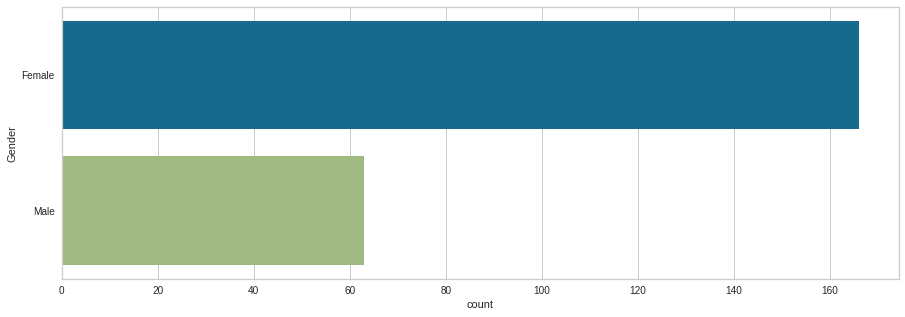

In [ ]:
plot_countplot(df, 'Gender')

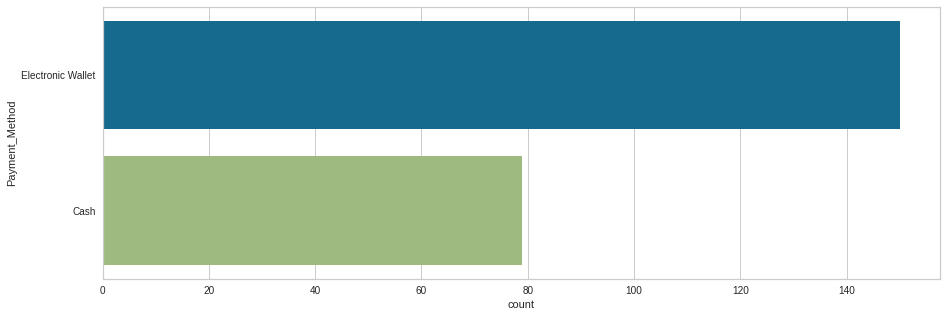

In [ ]:
plot_countplot(df, 'Payment_Method')

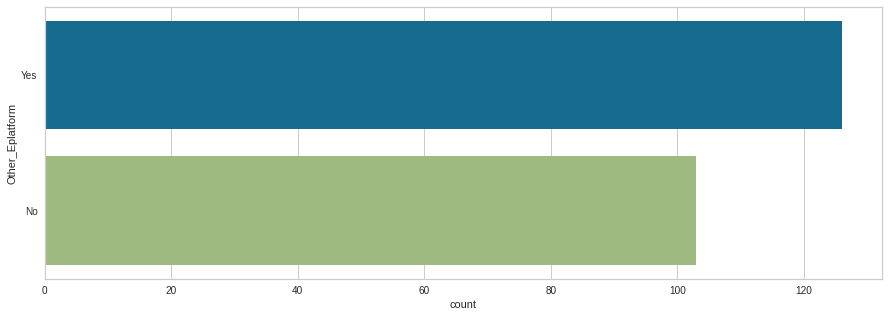

In [ ]:
plot_countplot(df, 'Other_Eplatform')

# QUESTIONS 

In order to deeply understand the dataset, our group decides to make some questions and apply statistical test. For each statistical test, we would apply ANOVA test, Chi Square Test or find the correlation based on the nature of the test

* Reference for ANOVA test: https://www.geeksforgeeks.org/how-to-perform-a-one-way-anova-in-python/
* Reference for correlation: https://www.kaggle.com/code/kushal1996/customer-segmentation-k-means-analysis/notebook
* Reference for Chi Square test: https://towardsdatascience.com/chi-square-test-how-to-calculate-chi-square-using-formula-python-implementation-6da203f96569


1. Is there a **relation between age and the tendency to use different payment method**? - Because this is between the continuous and categorical variables, we can perform ANOVA test and use visualization to understand this relation.
2. Is there a **relation between gender and the tendency to make orders - spending per order**? - Because this is between the continuous and categorical variables, we can perform ANOVA test and use visualization to understand this relation. With regards to the relation between categorical and categorical value, we will use chi-square test
3. Is there a relation between monthly net income and the monthly spending value? - Because this is between the continuous and categorical variables, we can perform ANOVA test and use visualization to understand this relation.
4. We will also identify the relation between the continuous variables which are age, net income and average number of orders made

In [ ]:
# Function to detect and remove outliers. This is useful prior to performing the statistical test
def remove_outliers(dataframe, feature):
  Q1 = np.percentile(dataframe[feature], 25, interpolation = 'midpoint')
  Q3 = np.percentile(dataframe[feature], 75, interpolation = 'midpoint')
  IQR = Q3 - Q1
  upper = np.where(dataframe[feature] >= (Q3+1.5*IQR))
  lower = np.where(dataframe[feature] <= (Q1-1.5*IQR))

  dataframe.drop(upper[0], axis=0, inplace=True)
  dataframe.drop(lower[0], axis=0, inplace=True)

  return dataframe.reset_index(drop=True)

In [ ]:
df = remove_outliers(df, 'Average_Order')
df = remove_outliers(df, 'Age')
df = remove_outliers(df, 'Net_Income')
df = df[df['Net_Income']<=60000000] # There are some people whose net_income seems to be too large and this may affect our segmentation. They are not outliers but the special space that we do not want to consider

In [ ]:
# Function to detect and remove outliers. This is useful prior to performing the statistical test
def fill_missing_value(dataframe, feature):
  list_null_index = dataframe[dataframe[feature].isnull()].index.tolist() # take a list of null indices
  list_fill = [] # create a list to fill missing values

  for index in list_null_index:
    spending_group = dataframe.iloc[index]['Spending_Per_Order'] # extract the spending group of that customer whose net value is missing
    mean_net_income_spending_group = dataframe[dataframe['Spending_Per_Order']==spending_group]['Net_Income'].mean() # find the mean net income of the customers belonging to that group
    list_fill.append(mean_net_income_spending_group) # add that spending to the spending list to fill missing values

  for index, filled_value in zip(list_null_index, list_fill):
    dataframe.at[index,'Net_Income'] = filled_value # fill missing values
  
  return dataframe

In [ ]:
df = fill_missing_value(df, 'Net_Income')

In [ ]:
df_cluster = df.copy(deep=True)

Firstly, we would find the correlation between the age and net income in order to understand the relation between these features

In [ ]:
x_simple = np.array(df['Age'])
y_simple = np.array(df['Net_Income'])
my_rho = np.corrcoef(x_simple, y_simple)

print(my_rho)
# The correlation value between Age and Net Income is approximately 0.5, which indicates a positive relationship.

[[1.         0.50686836]
 [0.50686836 1.        ]]


Secondly, we will find the correlation value between age and the monthly average number of orders made

In [ ]:
x_simple = np.array(df['Age'])
y_simple = np.array(df['Average_Order'])
my_rho = np.corrcoef(x_simple, y_simple)

print(my_rho)
# The correlation value between Age and Average Order is -0.66, which indicates a negative relationship.

[[ 1.         -0.65536308]
 [-0.65536308  1.        ]]


Next, the correlation between monthly net income and monthly average number of orders made is computed

In [ ]:
x_simple = np.array(df['Net_Income'])
y_simple = np.array(df['Average_Order'])
my_rho = np.corrcoef(x_simple, y_simple)

print(my_rho)
# The correlation value between Net Income and Average Order is -0.47, which indicates a negative relationship.

[[ 1.        -0.4711929]
 [-0.4711929  1.       ]]




---



In order to answer the questions about whether different age will have different tendency for the payment method on Shopee, we perform the ANOVA test

In [ ]:
# Age and Payment Method
# Payment_Method = 'Cash'
# Payment_Method = 'Electronic Wallet'

age_cash = df[df['Payment_Method']=='Cash']['Age']
age_ewallet = df[df['Payment_Method']=='Electronic Wallet']['Age']

In [ ]:
f_oneway(age_cash, age_ewallet)

F_onewayResult(statistic=0.010533057698448572, pvalue=0.9183637586325449)

Since the p-value is larger than 0.05 (0,918 > 0.05) indicates strong evidence for the null hypothesis. This means we retain the null hypothesis and reject the alternative hypothesis. This implies that we have sufficient proof to say that age do not affect the payment by cash or e-wallet

In order to understand whether gender would influence the habit of making orders on Shopee, ANOVA test would be useful there

In [ ]:
# Gender and Average_Order
# Gender = 'Male'
# Gender = 'Female'

avg_order_male = df[df['Gender']=='Male']['Average_Order']
avg_order_female = df[df['Gender']=='Female']['Average_Order']

In [ ]:
f_oneway(avg_order_male,avg_order_female)

F_onewayResult(statistic=6.3757764126774505, pvalue=0.012382085682943281)

Since the p-value is larger than 0.05 (0,012 < 0.05) hence we would reject the null hypothesis. This implies that we have sufficient proof to say that there exists a difference in average order among two different gender group.


Next, Chi square test is applied to understand whether customers of different genders will have a different tendency in terms of their spending per order

In [ ]:
# Gender and Spending_Per_Order
# Gender = 'Male'
# Gender = 'Female'
# Spending_Per_Order = 'Below 100.000'
# Spending_Per_Order = '100.000-300.000'
# Spending_Per_Order = '300.000-500.000'
# Spending_Per_Order = 'Over 500.000'

#----------step 1: Extract required columns, ideally it should be two columns at a time
data_interim = df[['Gender', 'Spending_Per_Order']]
#----------step 2: Create a cross tab which is a contigency table
data_cont = pd.crosstab(data_interim['Gender'], data_interim['Spending_Per_Order'])

stat, p, dof, expected = chi2_contingency(data_cont)
#-----------interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    
    print('Dependent (reject H0)')
    
else:
    print('Independent (H0 holds true)')

p value is 0.7760437347284835
Independent (H0 holds true)


Because H0 holds true, we can deduce that there is no difference between gender and the spending per order.

In [ ]:
# Net_Income and Spending_Per_Order
# Spending_Per_Order = 'Below 100.000'
# Spending_Per_Order = '100.000-300.000'
# Spending_Per_Order = '300.000-500.000'
# Spending_Per_Order = 'Over 500.000'
income_spend_below_100 = df[df['Spending_Per_Order']=='Below 100.000']['Net_Income']
income_spend_between_100_300 = df[df['Spending_Per_Order']=='100.000 - 300.000']['Net_Income']
income_spend_between_300_500 = df[df['Spending_Per_Order']=='300.000 - 500.000']['Net_Income']
income_spend_over_500 = df[df['Spending_Per_Order']=='Over 500.000']['Net_Income']

In [ ]:
f_oneway(income_spend_below_100,income_spend_between_100_300,income_spend_between_300_500,income_spend_over_500)

F_onewayResult(statistic=69.09775443246272, pvalue=3.283178198867041e-30)

Since the p-value is larger than 0.05 (3.283e-30 < 0.05) hence we would reject the null hypothesis.This implies that we have sufficient proof to say that there exists a difference in the net income among four different spending per order group. 

# EXPLORATORY DATA ANALYSIS

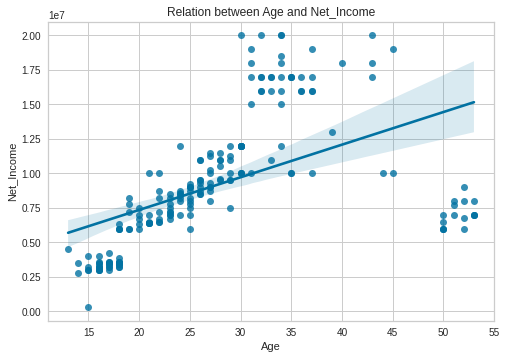

In [ ]:
# loading dataset
data = df

# draw regplot
sns.regplot(x = "Age",
			y = "Net_Income",
			data = data)

# show the plot
plt.title("Relation between Age and Net_Income")
plt.show()

The correlation between Age and Net Income is positive because higher Age corresponds to a larger Net Income and vice versa.

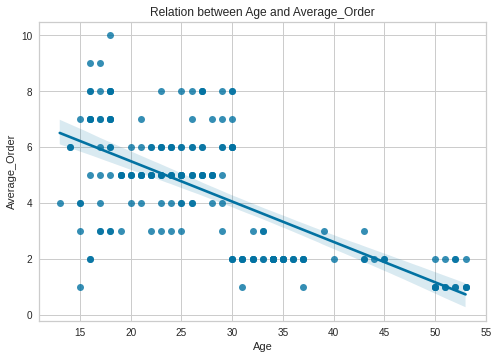

In [ ]:
# loading dataset
data = df

# draw regplot
sns.regplot(x = "Age",
			y = "Average_Order",
			data = data)

# show the plot
plt.title("Relation between Age and Average_Order")
plt.show()

The correlation between Age and Average Order is negative because higher Age corresponds to a smaller Average_Order and vice versa.

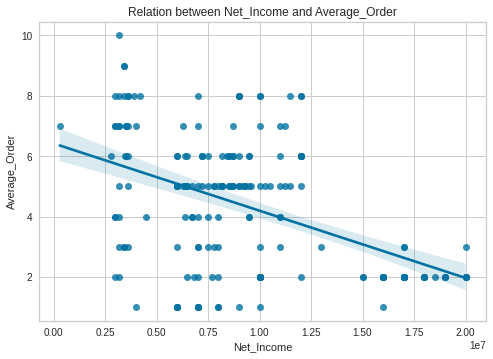

In [ ]:
# loading dataset
data = df

# draw regplot
sns.regplot(x = "Net_Income",
			y = "Average_Order",
			data = data)

# show the plot
plt.title("Relation between Net_Income and Average_Order")
plt.show()

The correlation between Net Income and Average Order is negative because higher Net Income corresponds to a smaller Average Order and vice versa.

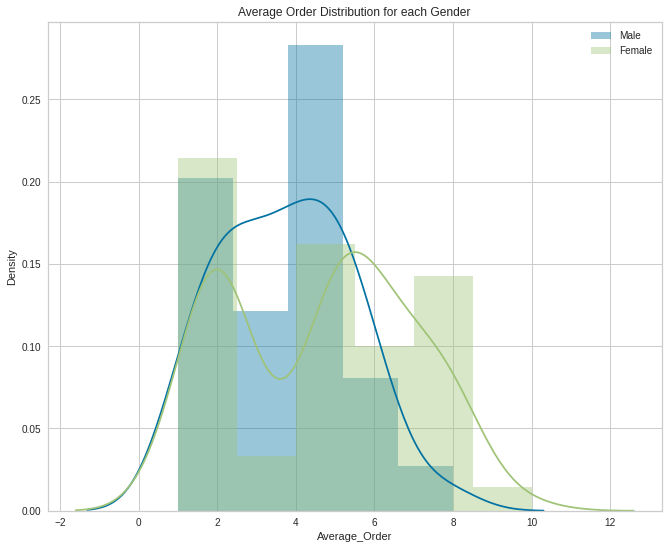

In [ ]:
f, ax = plt.subplots( figsize = (11,9) )  
sns.distplot( df[df.Gender == 'Male'].Average_Order, ax = ax, label = 'Male')  
sns.distplot( df[df.Gender == 'Female'].Average_Order, ax = ax, label = 'Female')  
plt.title( 'Average Order Distribution for each Gender' )  
plt.legend()  
plt.show()  

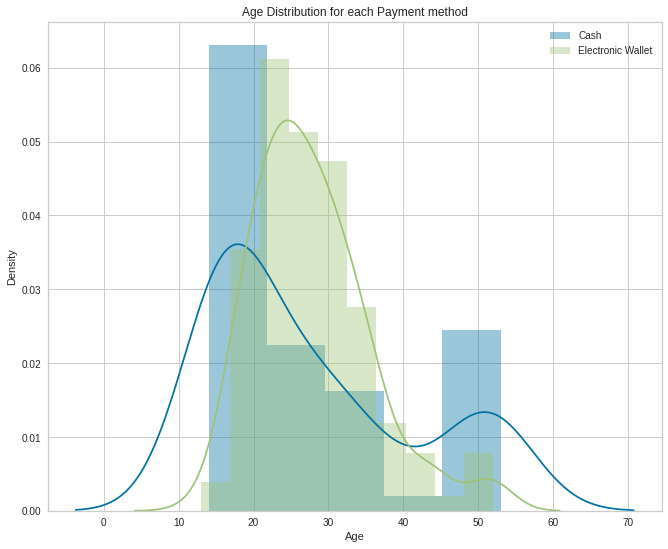

In [ ]:
f, ax = plt.subplots( figsize = (11,9) )  
sns.distplot( df[df.Payment_Method == 'Cash'].Age, ax = ax, label = 'Cash')  
sns.distplot( df[df.Payment_Method == 'Electronic Wallet'].Age, ax = ax, label = 'Electronic Wallet')  
plt.title( 'Age Distribution for each Payment method' )  
plt.legend()  
plt.show()  

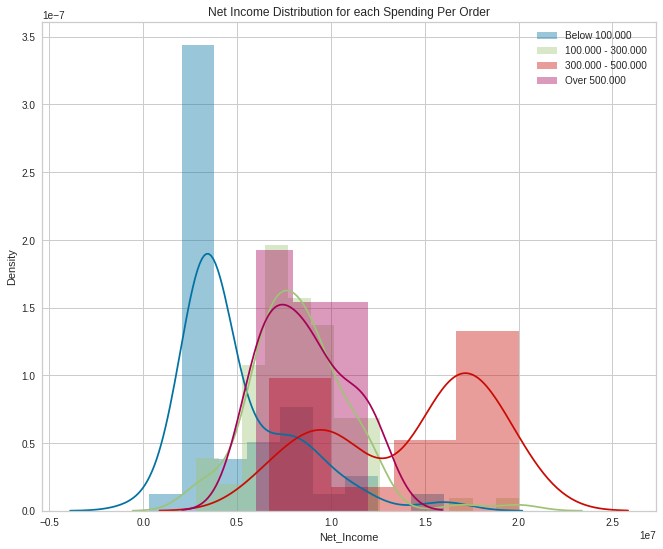

In [ ]:
f, ax = plt.subplots( figsize = (11,9) )  
sns.distplot( df[df.Spending_Per_Order == 'Below 100.000'].Net_Income, ax = ax, label = 'Below 100.000')  
sns.distplot( df[df.Spending_Per_Order == '100.000 - 300.000'].Net_Income, ax = ax, label = '100.000 - 300.000') 
sns.distplot( df[df.Spending_Per_Order == '300.000 - 500.000'].Net_Income, ax = ax, label = '300.000 - 500.000')  
sns.distplot( df[df.Spending_Per_Order == 'Over 500.000'].Net_Income, ax = ax, label = 'Over 500.000')   
plt.title( 'Net Income Distribution for each Spending Per Order' )  
plt.legend()  
plt.show()  

# DATA PREPARATION

## DETECT OUTLIERS

The outliers are apparent in the age, net income, and average number of orders features. Therefore, these values need to be detected and removed.

Our approach to removing outliers is Interquartile Range (IQR)

The quartiles of a ranked set of data values are three points which divide the data into exactly four equal parts, each part comprising of quarter data. 

1. Q1 is defined as the middle number between the smallest number and the median of the data set.
2. Q2 is the median of the data.
3. Q3 is the middle value between the median and the highest value of the data set.

In [ ]:
# # Function to detect and remove outliers
# def remove_outliers(dataframe, feature):
#   Q1 = np.percentile(dataframe[feature], 25, interpolation = 'midpoint')
#   Q3 = np.percentile(dataframe[feature], 75, interpolation = 'midpoint')
#   IQR = Q3 - Q1
#   upper = np.where(dataframe[feature] >= (Q3+1.5*IQR))
#   lower = np.where(dataframe[feature] <= (Q1-1.5*IQR))

#   dataframe.drop(upper[0], axis=0, inplace=True)
#   dataframe.drop(lower[0], axis=0, inplace=True)

#   return dataframe.reset_index(drop=True)

In [ ]:
# df = remove_outliers(df, 'Average_Order')
# df = remove_outliers(df, 'Age')
# df = remove_outliers(df, 'Net_Income')
# df = df[df['Net_Income']<=60000000] # There are some people whose net_income seems to be too large and this may affect our segmentation

In [ ]:
print('The shape of the dataset after removing outliers is: ', df.shape) # 208 rows, 7 columns

The shape of the dataset after removing outliers is:  (193, 7)


## IMPUTATION

**Imputation** is a technique used for replacing the missing data with some **substitute value** to retain most of the data/information of the dataset.

The missing values are from the **net income** (income after tax). Our approach to this is to fill the **missing net income** with the **mean value of the net income** corresponding to the **average spending group**. 

For example, if a person with an average spending per order is below 100.000 VND and his monthly net income is missing, that value would be replaced by the **mean average spending per order** of all people whose **average expenditure per order is below 100.000 VND**

The reason for this approach is that there is a **high correlation** between the monthly average net income with the average spending per order


In [ ]:
# print('The description of the number of null records for each feature: \n', df.isnull().sum())

In [ ]:
# def fill_missing_value(dataframe, feature):
#   list_null_index = dataframe[dataframe[feature].isnull()].index.tolist() # take a list of null indices
#   list_fill = [] # create a list to fill missing values

#   for index in list_null_index:
#     spending_group = dataframe.iloc[index]['Spending_Per_Order'] # extract the spending group of that customer whose net value is missing
#     mean_net_income_spending_group = dataframe[dataframe['Spending_Per_Order']==spending_group]['Net_Income'].mean() # find the mean net income of the customers belonging to that group
#     list_fill.append(mean_net_income_spending_group) # add that spending to the spending list to fill missing values

#   for index, filled_value in zip(list_null_index, list_fill):
#     dataframe.at[index,'Net_Income'] = filled_value # fill missing values
  
#   return dataframe

In [ ]:
# df = fill_missing_value(df, 'Net_Income')

In [ ]:
print('The description of the number of null records for each feature after imputation: \n', df.isnull().sum())

The description of the number of null records for each feature after imputation: 
 Gender                0
Age                   0
Net_Income            0
Average_Order         0
Spending_Per_Order    0
Payment_Method        0
Other_Eplatform       0
dtype: int64


## CONVERT CATEGORICAL VALUE

The dataset contains some categorical features which are:
1. Gender
2. Average spending per order
3. Payment method
4. The tedency to use other e-commerce platforms

In order to run the clustering analysis, these features would have to be encoded. Our approach is to apply label encoding for these features. Label Encoding is a popular encoding technique for handling categorical variables. In this technique, each label is assigned a unique integer based on alphabetical ordering. In the above scenario, the spending per order has an order or rank.

In [ ]:
gender_dict = {'Female':0, 'Male':1}
payment_method_dict = {'Cash':0,
                       'Electronic Wallet':1}
other_eplatform_dict = {'No':0,
                        'Yes':1}

In [ ]:
def convert_categorical(dataframe, feature_lists, dict_lists):
  for feature, dict_list in zip(feature_lists, dict_lists):
    dataframe[feature] = dataframe[feature].map(dict_list)
  return dataframe

In [ ]:
df = convert_categorical(df, ['Gender', 'Payment_Method', 'Other_Eplatform'], [gender_dict,  payment_method_dict, other_eplatform_dict])
df = pd.get_dummies(df, 'Spending_Per_Order', drop_first=True)

In [ ]:
df.rename(columns={"Spending_Per_Order_300.000 - 500.000":"Spending_300000_500000",
                   "Spending_Per_Order_Below 100.000":"Spending_Below_100000",
                   "Spending_Per_Order_Over 500.000":"Spending_Over_500000"}, inplace=True)

In [ ]:
df.head(5)

,Gender,Age,Net_Income,Average_Order,Payment_Method,Other_Eplatform,Spending_300000_500000,Spending_Below_100000,Spending_Over_500000
0,0,18,6000000.0,6,1,1,0,0,0
1,0,21,6500000.0,5,1,1,0,0,0
2,1,25,7000000.0,3,1,1,0,0,0
3,0,23,7000000.0,8,1,1,0,0,0
4,0,27,9000000.0,6,1,1,0,0,0


## STANDARDIZATION

Since clustering algorithms including kmeans use distance-based measurements to determine the similarity between data points, it’s recommended to standardize the data to have a mean of zero and a standard deviation of one since almost always the features in any dataset would have different units of measurements such as age vs income.

In [ ]:
scaler_age = StandardScaler()
scaler_income = StandardScaler()
scaler_order = StandardScaler()

In [ ]:
df['Age'] = scaler_age.fit_transform(df[['Age']])
df['Net_Income'] = scaler_age.fit_transform(df[['Net_Income']])
df['Average_Order'] = scaler_age.fit_transform(df[['Average_Order']])

In [ ]:
df.head(5)

,Gender,Age,Net_Income,Average_Order,Payment_Method,Other_Eplatform,Spending_300000_500000,Spending_Below_100000,Spending_Over_500000
0,0,-0.975565,-0.683130,0.737453,1,1,0,0,0
1,0,-0.674632,-0.575677,0.282730,1,1,0,0,0
2,1,-0.273387,-0.468225,-0.626717,1,1,0,0,0
3,0,-0.474009,-0.468225,1.646900,1,1,0,0,0
4,0,-0.072765,-0.038416,0.737453,1,1,0,0,0


# SAVE CLEAN DATA

In [ ]:
df.to_csv('clean_dataframe.csv', index=False)

# CUSTOMER SEGMENTATION

In [ ]:
clean_df = pd.read_csv('/content/drive/MyDrive/Compulsory Elective Subject - Andersson/clean_dataframe.csv')

## ELBOW METHOD

The elbow method is used to determine the optimal number of clusters in k-means clustering. The elbow method plots the value of the cost function produced by different values of k. As you know, if k increases, average distortion will decrease, each cluster will have fewer constituent instances, and the instances will be closer to their respective centroids. However, the improvements in average distortion will decline as k increases. The value of k at which improvement in distortion declines the most is called the elbow, at which we should stop dividing the data into further clusters.

Reference: https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml

https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/



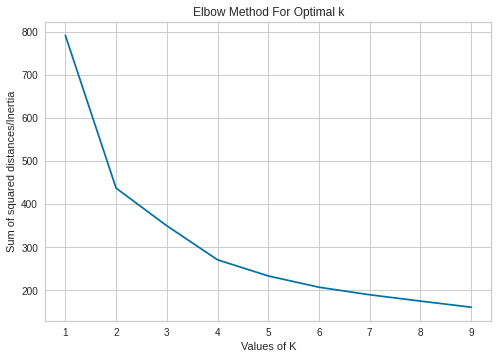

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(clean_df)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()


The curve looks like an elbow. In the above plot, the elbow is at k=4 (i.e. Sum of squared distances falls suddenly) indicating the optimal k for this dataset is 4.

## SILHOUETTE METHOD

The silhouette Method is also a method to find the optimal number of clusters and interpretation and validation of consistency within clusters of data. The silhouette method computes silhouette coefficients of each point that measure how much a point is similar to its own cluster compared to other clusters. by providing a succinct graphical representation of how well each object has been classified.

Reference: https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891


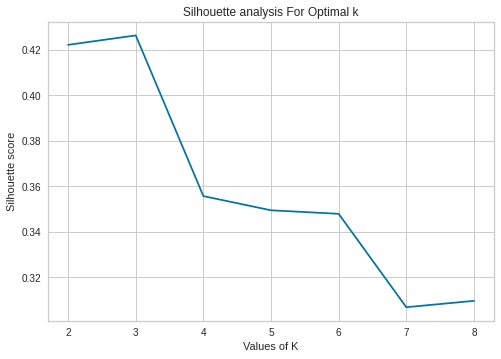

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(clean_df)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(clean_df, cluster_labels))
 
plt.plot(range_n_clusters,silhouette_avg,'bx-')

plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

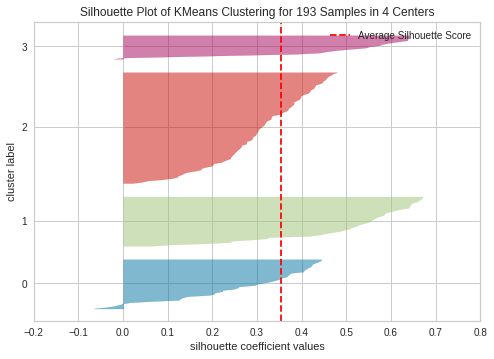

In [ ]:
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(clean_df)       
visualizer.show()   

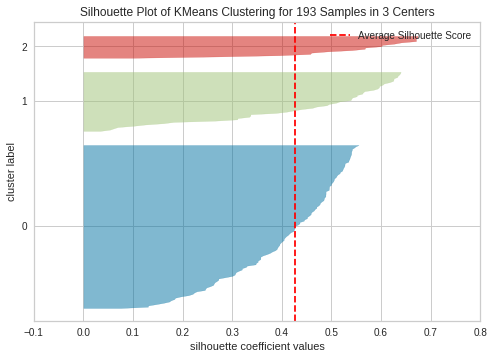

In [ ]:
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(clean_df)       
visualizer.show()   

We see that the silhouette score is maximized at k = 3. So, we will take 3 clusters.


## PERFORM KMEANS CLUSTERING

In [ ]:
df_cluster.head(3)

,Gender,Age,Net_Income,Average_Order,Spending_Per_Order,Payment_Method,Other_Eplatform,cluster
0,Female,18,6000000.0,6,100.000 - 300.000,Electronic Wallet,Yes,2
1,Female,21,6500000.0,5,100.000 - 300.000,Electronic Wallet,Yes,2
2,Male,25,7000000.0,3,100.000 - 300.000,Electronic Wallet,Yes,2


In [ ]:
kmeans = KMeans(n_clusters=4).fit(clean_df)
prediction = kmeans.predict(clean_df)
df_cluster['cluster'] = prediction

In [ ]:
df_cluster.head(3)

,Gender,Age,Net_Income,Average_Order,Spending_Per_Order,Payment_Method,Other_Eplatform,cluster
0,Female,18,6000000.0,6,100.000 - 300.000,Electronic Wallet,Yes,2
1,Female,21,6500000.0,5,100.000 - 300.000,Electronic Wallet,Yes,2
2,Male,25,7000000.0,3,100.000 - 300.000,Electronic Wallet,Yes,2


# CONCLUSION FROM MODEL

Now we would derive the insights from these customer segments

In [ ]:
df_cluster.groupby('cluster')[['Age','Net_Income','Average_Order']].mean()

,Age,Net_Income,Average_Order
cluster,,,
0,16.555556,3.301389e+06,6.027778
1,34.813953,1.615116e+07,2.046512
2,24.437500,8.595312e+06,5.364583
3,50.666667,7.388889e+06,1.388889


In [ ]:
df_cluster.groupby(['cluster','Spending_Per_Order'])['Spending_Per_Order'].count()

cluster  Spending_Per_Order
0        100.000 - 300.000     58
         300.000 - 500.000     12
         Below 100.000          8
         Over 500.000          13
1        100.000 - 300.000      6
         300.000 - 500.000     36
         Below 100.000          1
2        100.000 - 300.000      7
         Below 100.000         34
3        100.000 - 300.000     12
         300.000 - 500.000      4
         Below 100.000          2
Name: Spending_Per_Order, dtype: int64

In [ ]:
df_cluster.groupby(['cluster','Payment_Method'])['Payment_Method'].count()

cluster  Payment_Method   
0        Cash                 29
         Electronic Wallet     7
1        Cash                  6
         Electronic Wallet    37
2        Cash                 15
         Electronic Wallet    81
3        Cash                 13
         Electronic Wallet     5
Name: Payment_Method, dtype: int64

In [ ]:
df_cluster.groupby(['cluster','Other_Eplatform'])['Other_Eplatform'].count()

cluster  Other_Eplatform
0        No                 11
         Yes                25
1        No                 35
         Yes                 8
2        No                 20
         Yes                76
3        No                 16
         Yes                 2
Name: Other_Eplatform, dtype: int64

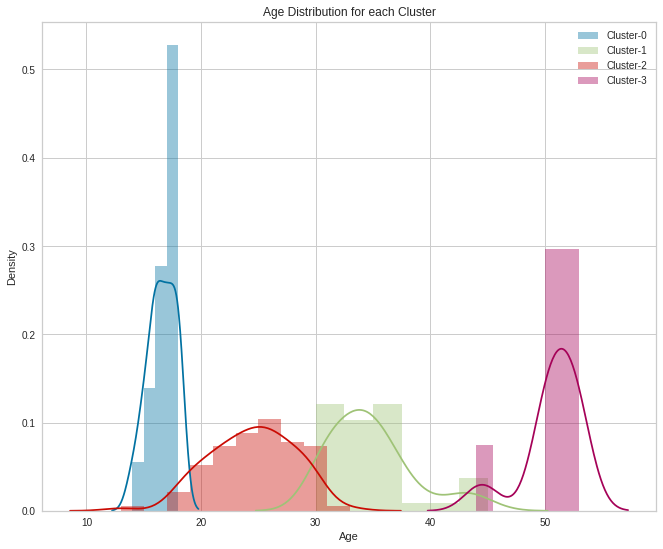

In [ ]:
f, ax = plt.subplots( figsize = (11,9) )  
sns.distplot( df_cluster[df_cluster.cluster == 0].Age, ax = ax, label = 'Cluster-0')  
sns.distplot( df_cluster[df_cluster.cluster == 1].Age, ax = ax, label = 'Cluster-1')  
sns.distplot( df_cluster[df_cluster.cluster == 2].Age, ax = ax, label = 'Cluster-2')  
sns.distplot( df_cluster[df_cluster.cluster == 3].Age, ax = ax, label = 'Cluster-3')  
plt.title( 'Age Distribution for each Cluster' )  
plt.legend()  
plt.show()  

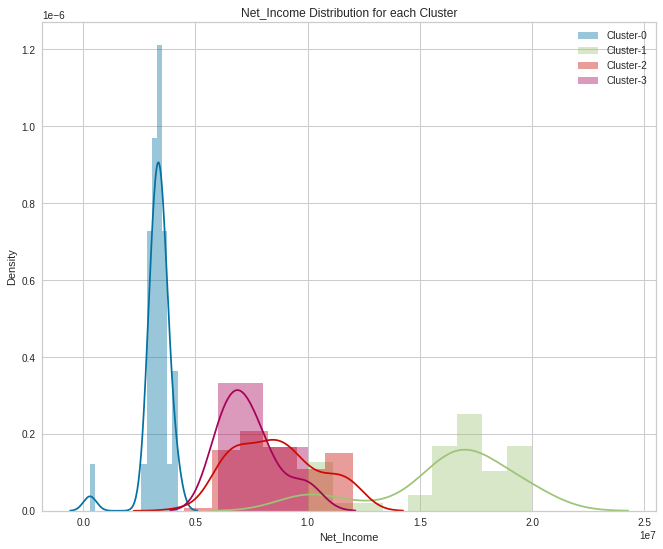

In [ ]:
f, ax = plt.subplots( figsize = (11,9) )  
sns.distplot( df_cluster[df_cluster.cluster == 0].Net_Income, ax = ax, label = 'Cluster-0')  
sns.distplot( df_cluster[df_cluster.cluster == 1].Net_Income, ax = ax, label = 'Cluster-1')  
sns.distplot( df_cluster[df_cluster.cluster == 2].Net_Income, ax = ax, label = 'Cluster-2')  
sns.distplot( df_cluster[df_cluster.cluster == 3].Net_Income, ax = ax, label = 'Cluster-3')  

plt.title( 'Net_Income Distribution for each Cluster' )  
plt.legend()  
plt.show()  

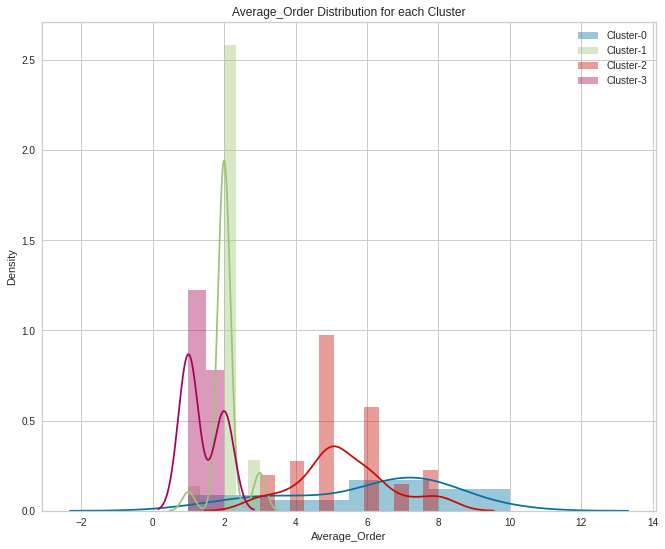

In [ ]:
f, ax = plt.subplots( figsize = (11,9) )  
sns.distplot( df_cluster[df_cluster.cluster == 0].Average_Order, ax = ax, label = 'Cluster-0')  
sns.distplot( df_cluster[df_cluster.cluster == 1].Average_Order, ax = ax, label = 'Cluster-1')  
sns.distplot( df_cluster[df_cluster.cluster == 2].Average_Order, ax = ax, label = 'Cluster-2')  
sns.distplot( df_cluster[df_cluster.cluster == 3].Average_Order, ax = ax, label = 'Cluster-3')  

plt.title( 'Average_Order Distribution for each Cluster' )  
plt.legend()  
plt.show()  